#### Set up the environment - packages, models and dataset

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, fbeta_score
from sklearn.metrics import precision_recall_curve, roc_curve, log_loss
from sklearn.metrics import make_scorer, confusion_matrix

from time import time

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline

In [36]:
model_names = ["knn", "rf", "et", "xgb"]

for model_name in model_names:
    with open(f"{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [37]:
model_list

[('knn', KNeighborsClassifier(n_neighbors=8)),
 ('rf', RandomForestClassifier(n_estimators=164)),
 ('et', ExtraTreesClassifier(n_estimators=23)),
 ('xgb',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.7,
                enable_categorical=False, gamma=0, gpu_id=-1,
                importance_type=None, interaction_constraints='',
                learning_rate=1.2093472472994864, max_delta_step=0, max_depth=3,
                min_child_weight=13.0, missing=nan, monotone_constraints='()',
                n_estimators=300, n_jobs=8, num_parallel_tree=1, predictor='auto',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.3,
                subsample=0.6, tree_method='exact', validate_parameters=1,
                verbosity=None))]

In [38]:
df = pd.read_csv("features_clean.csv").iloc[:,1:]
df = df.fillna(df.median())

In [39]:
x, xho, y, yho = train_test_split(df.iloc[:,1:], df.flag, test_size=0.2, random_state=2018)
xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.25, random_state=2019)

#### Lets evaluate model performance - overall classification quality and runtime

In [72]:
stopwatch = []

for model_name in model_names:
    t0 = time()
    curr_model = eval(model_name)
    print(f'{model_name} \t score: {curr_model.score(xho, yho)} \t time: {time() - t0:.4f}')
    stopwatch.append(time() - t0)

knn 	 score: 0.8981670061099797 	 time: 0.2265
rf 	 score: 0.9938900203665988 	 time: 0.0282
et 	 score: 0.9918533604887984 	 time: 0.0066
xgb 	 score: 0.9862525458248472 	 time: 0.0037


In [66]:
stopwatch.sort()

In [67]:
stopwatch[:1]
for i in stopwatch:
    print("{:.1f}".format(i/stopwatch[0]))

1.0
1.8
7.5
60.6


Rebased model runtimes to XGBoost for easier comparison (or, in the multiples of XGBoost's runtime)

RandomForest and Extra Trees are preferred here with the highest classification quality - frankly, the speed itself won't be the deciding factor when screening for one Ethereum address if the model is deployed

#### Continuing model evaluation - Confusion Matrix

In [73]:
def make_confusion_matrix(model, threshold=0.5):
    y_predict = (model.predict_proba(xho)[:, 1] >= threshold)
    model_confusion = confusion_matrix(yho, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Fraud', 'Legit'],
           yticklabels=['Fraud', 'Legit']);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'RandomForest confusion matrix')
    
    print("Precision: {:6.4f}, Recall: {:6.4f}, F Beta: {:6.4f}".format(precision_score(yho, y_predict), 
                                                     recall_score(yho, y_predict), fbeta_score(yho,y_predict, beta=1.5)))

In [78]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(knn, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [79]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(rf, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [80]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(xgb, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [81]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(et, threshold), threshold=(0.0,1.0,0.02))

#optimal threshold is at 0.64

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

RandomForest and Extra Trees can reach or close to 100% precision with adjustments to threshold adjustments - lets have another look at these two models below

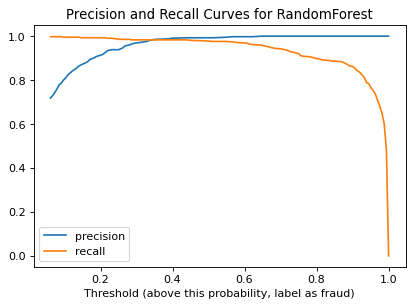

In [82]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(yho, rf.predict_proba(xho)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves for RandomForest');

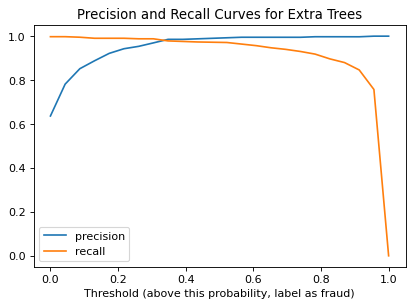

In [83]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(yho, et.predict_proba(xho)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves for Extra Trees');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ROC AUC score, kNN = 	 	 0.91919
ROC AUC score, RandomForest = 	 0.99929
ROC AUC score, Extra Trees = 	 0.99802
ROC AUC score, XGBoost = 	 0.99643


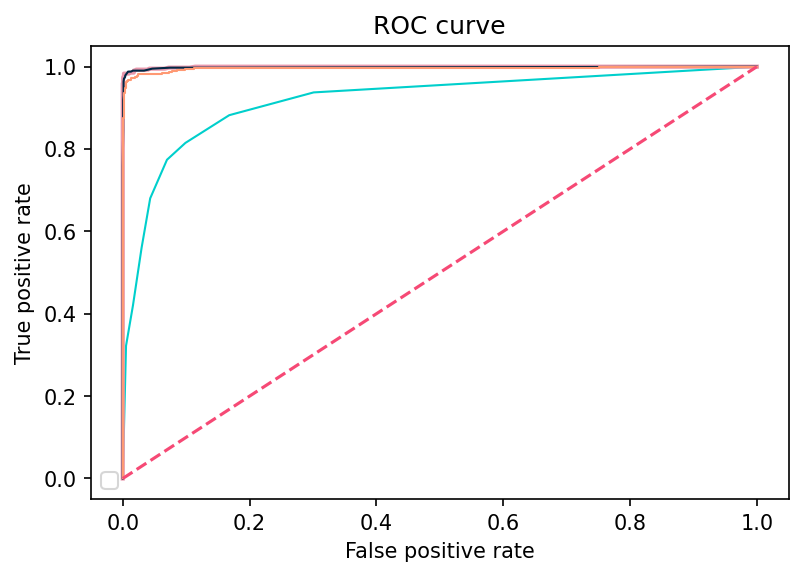

In [47]:
fpr, tpr, thresholds = roc_curve(yho, knn.predict_proba(xho)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(yho, rf.predict_proba(xho)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(yho, et.predict_proba(xho)[:,1])
fpr4, tpr4, thresholds4 = roc_curve(yho, xgb.predict_proba(xho)[:,1])

plt.figure(dpi=150,facecolor='1')

plt.plot(fpr, tpr,lw=1, c='#00cfcc')
plt.plot(fpr2, tpr2,lw=2, c='#e898ac')
plt.plot(fpr3, tpr3,lw=1, c='#002845')
plt.plot(fpr4, tpr4,lw=1, c='#ff9973')

plt.plot([0,1],[0,1],c='#f64975',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower left')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

print("ROC AUC score, kNN = \t \t", '{0:.5f}'.format(roc_auc_score(yho, knn.predict_proba(xho)[:,1])))
print("ROC AUC score, RandomForest = \t", '{0:.5f}'.format(roc_auc_score(yho, rf.predict_proba(xho)[:,1])))
print("ROC AUC score, Extra Trees = \t", '{0:.5f}'.format(roc_auc_score(yho, et.predict_proba(xho)[:,1])))
print("ROC AUC score, XGBoost = \t", '{0:.5f}'.format(roc_auc_score(yho, xgb.predict_proba(xho)[:,1])))

In [48]:
print("Log-loss on kNN: \t\t {:.4f}".format(log_loss(yho, knn.predict_proba(xho))))
print("Log-loss on RandomForest: \t {:.4f}".format(log_loss(yho, rf.predict_proba(xho))))
print("Log-loss on Extra Trees: \t {:.4f}".format(log_loss(yho, et.predict_proba(xho))))
print("Log-loss on XGBoost: \t\t {:.4f}".format(log_loss(yho, xgb.predict_proba(xho))))

Log-loss on kNN: 		 0.7858
Log-loss on RandomForest: 	 0.0358
Log-loss on Extra Trees: 	 0.0487
Log-loss on XGBoost: 		 0.0464
